# Random Swim - EPS 109 Final Project
## Allen Li (3033789230)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


#### Read in our dataset and extract a dataframe for each whale sorted by date and time

In [2]:
data = pd.read_csv('obis_seamap_dataset_1261_points.csv')[['latitude', 'longitude', 'series_id', 'date_time']]
whales = data['series_id'].unique()

whale_to_data = {}
for whale in whales:
    whale_to_data[whale] = data[data['series_id'] == whale].sort_values('date_time')

#### Meet our whales!

In [3]:
sorted(whales)

[112692, 112699, 112701, 112703, 112705]

Example of a specifc whale's dataframe

In [4]:
whale_to_data[112692]

latitude  longitude  series_id            date_time
4652 -64.806000 -63.894989     112692  2012-01-03 15:14:21
4828 -64.808998 -63.910004     112692  2012-01-03 15:14:21
5153 -64.805000 -63.919006     112692  2012-01-03 15:59:26
5154 -64.805000 -63.919006     112692  2012-01-03 15:59:37
809  -64.810997 -63.924988     112692  2012-01-03 16:54:32
...         ...        ...        ...                  ...
3647 -63.224999 -63.365997     112692  2012-03-03 23:28:08
1225 -63.676998 -64.425995     112692  2012-03-04 21:11:43
1034 -63.507000 -63.639008     112692  2012-03-05 21:25:45
4793 -63.719002 -63.087006     112692  2012-03-06 20:33:13
929  -63.959999 -63.712006     112692  2012-03-07 21:36:27

[421 rows x 4 columns]

#### Find the average speed of a whale in km/h for our random swim simulation later on

In [5]:
whale_to_dist = {112703: 1989, 112692: 3865, 112705: 4515, 112701: 5076, 112699: 10525} # Extracted by hand from the OBIS website
whale_to_time = {}
speeds = []
for whale in whales:
    time = (dt.datetime.strptime(whale_to_data[whale]['date_time'].values[-1], '%Y-%m-%d %H:%M:%S') - dt.datetime.strptime(whale_to_data[whale]['date_time'].values[0], '%Y-%m-%d %H:%M:%S')).total_seconds()
    whale_to_time[whale] = time
    
speed_total = 0
for whale in whales:
    speed_total += int(whale_to_dist[whale]) / int(whale_to_time[whale]) * 60 * 60
    
speed_avg = speed_total / len(whales)
print("The average speed of the whales in the dataset is", np.round(speed_avg, 2), "km/h")

The average speed of the whales in the dataset is 2.82 km/h


The lat/lon resolution of the map I am using is 0.0042, which roughly equals 0.45 km. Since 2.82 km/h is roughly 0.45 km / 10 minutes, we can use a timestep of dt = 10 minutes to approximate a humpback whale's movement on the map by one position.

#### Test loading our map

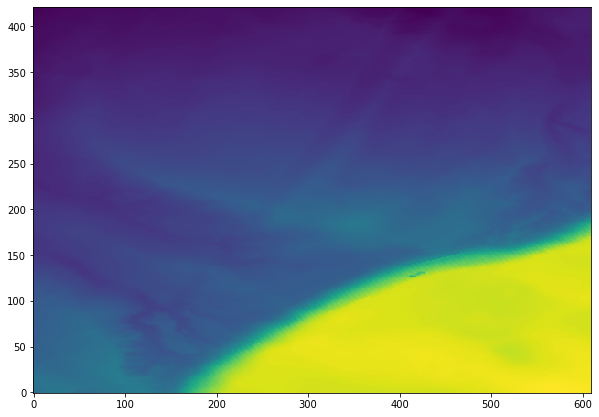

In [62]:
from netCDF4 import Dataset
map_data = Dataset('geodata_2.nc', mode='r')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.imshow(map_data['elevation'], origin='lower')

#### Find median change in latitude/longitude

In [8]:
lats = []
lons = []
for whale in whales:
    d = whale_to_data[whale][['latitude', 'longitude']].diff()
    change_in_lats = abs(d['latitude'])[1:].to_numpy()
    change_in_lons = abs(d['longitude'])[1:].to_numpy()
    lats.extend(change_in_lats)
    lons.extend(change_in_lons)

lat_med = np.round(sorted(lats)[len(lats) // 2], 3)
lon_med = np.round(sorted(lons)[len(lons) // 2], 3)
print("The median of changes in latitude is", lat_med)
print("The median of changes in longitude is", lon_med)

The median of changes in latitude is 0.009
The median of changes in longitude is 0.025


Anything below the median change in longitude/latitude will be considered "continuing" in the same direction as previously

#### Calculate probabilities of continuing straight, turning 45 degrees, turning 90 degrees, turning 135 degrees, and turning 180 degrees

In [9]:
def get_direction(curr, change):
    if curr == 'N':
        if abs(change[0]) < lat_med:
            if abs(change[0]) < lon_med:
                return curr, 0
            if change[1] < 0:
                return 'W', 90
            elif change[1] > 0:
                return 'E', 90
        else:
            if change[0] > 0:
                if abs(change[1]) < lat_med:
                    return 'N', 0
                elif change[1] > 0:
                    return 'NE', 45
                elif change[1] < 0:
                    return 'NW', 45
            else:
                if abs(change[1]) < lat_med:
                    return 'S', 180
                elif change[1] > 0:
                    return 'SE', 135
                elif change[1] < 0:
                    return 'SW', 135
    elif curr == 'S':
        if abs(change[0]) < lat_med:
            if abs(change[0]) < lon_med:
                return curr, 0
            if change[1] < 0:
                return 'W', 90
            elif change[1] > 0:
                return 'E', 90
        else:
            if change[0] > 0:
                if abs(change[1]) < lat_med:
                    return 'N', 180
                elif change[1] > 0:
                    return 'NE', 135
                elif change[1] < 0:
                    return 'NW', 135
            else:
                if abs(change[1]) < lat_med:
                    return 'S', 0
                elif change[1] > 0:
                    return 'SE', 45
                elif change[1] < 0:
                    return 'SW', 45
    elif curr == 'E':
        if abs(change[0]) < lat_med:
            if abs(change[0]) < lon_med:
                return curr, 0
            if change[1] < 0:
                return 'W', 180
            elif change[1] > 0:
                return 'E', 0
        else:
            if change[0] > 0:
                if abs(change[1]) < lat_med:
                    return 'N', 90
                elif change[1] > 0:
                    return 'NE', 45
                elif change[1] < 0:
                    return 'NW', 135
            else:
                if abs(change[1]) < lat_med:
                    return 'S', 90
                elif change[1] > 0:
                    return 'SE', 45
                elif change[1] < 0:
                    return 'SW', 135
    elif curr == 'W':
        if abs(change[0]) < lat_med:
            if abs(change[0]) < lon_med:
                return curr, 0
            if change[1] < 0:
                return 'W', 0
            elif change[1] > 0:
                return 'E', 180
        else:
            if change[0] > 0:
                if abs(change[1]) < lat_med:
                    return 'N', 90
                elif change[1] > 0:
                    return 'NE', 135
                elif change[1] < 0:
                    return 'NW', 45
            else:
                if abs(change[1]) < lat_med:
                    return 'S', 90
                elif change[1] > 0:
                    return 'SE', 135
                elif change[1] < 0:
                    return 'SW', 45
    elif curr == 'NE':
        if abs(change[0]) < lat_med:
            if abs(change[0]) < lon_med:
                return curr, 0
            if change[1] < 0:
                return 'W', 135
            elif change[1] > 0:
                return 'E', 45
        else:
            if change[0] > 0:
                if abs(change[1]) < lat_med:
                    return 'N', 45
                elif change[1] > 0:
                    return 'NE', 0
                elif change[1] < 0:
                    return 'NW', 90
            else:
                if abs(change[1]) < lat_med:
                    return 'S', 135
                elif change[1] > 0:
                    return 'SE', 90
                elif change[1] < 0:
                    return 'SW', 180
    elif curr == 'NW':
        if abs(change[0]) < lat_med:
            if abs(change[0]) < lon_med:
                return curr, 0
            if change[1] < 0:
                return 'W', 45
            elif change[1] > 0:
                return 'E', 135
        else:
            if change[0] > 0:
                if abs(change[1]) < lat_med:
                    return 'N', 45
                elif change[1] > 0:
                    return 'NE', 90
                elif change[1] < 0:
                    return 'NW', 0
            else:
                if abs(change[1]) < lat_med:
                    return 'S', 135
                elif change[1] > 0:
                    return 'SE', 180
                elif change[1] < 0:
                    return 'SW', 90
    elif curr == 'SE':
        if abs(change[0]) < lat_med:
            if abs(change[0]) < lon_med:
                return curr, 0
            if change[1] < 0:
                return 'W', 135
            elif change[1] > 0:
                return 'E', 45
        else:
            if change[0] > 0:
                if abs(change[1]) < lat_med:
                    return 'N', 135
                elif change[1] > 0:
                    return 'NE', 90
                elif change[1] < 0:
                    return 'NW', 180
            else:
                if abs(change[1]) < lat_med:
                    return 'S', 45
                elif change[1] > 0:
                    return 'SE', 0
                elif change[1] < 0:
                    return 'SW', 90
    else:
        if abs(change[0]) < lat_med:
            if abs(change[0]) < lon_med:
                return curr, 0
            if change[1] < 0:
                return 'W', 45
            elif change[1] > 0:
                return 'E', 135
        else:
            if change[0] > 0:
                if abs(change[1]) < lat_med:
                    return 'N', 135
                elif change[1] > 0:
                    return 'NE', 180
                elif change[1] < 0:
                    return 'NW', 90
            else:
                if abs(change[1]) < lat_med:
                    return 'S', 45
                elif change[1] > 0:
                    return 'SE', 0
                elif change[1] < 0:
                    return 'SW', 90

In [10]:
direction_counts = {0:0, 45:0, 90:0, 135:0, 180:0, 'total':0}

for whale in whales:
    d = whale_to_data[whale][['latitude', 'longitude']].diff()
    start = (d.iloc[1]['latitude'], d.iloc[1]['longitude'])
    direction, degree = get_direction('N', start)
    for i in range(2, len(d)):
        direction, degree = get_direction(direction, (d.iloc[i]['latitude'], d.iloc[i]['longitude']))
        if degree is not None:
            direction_counts[degree] += 1
            direction_counts['total'] += 1

In [11]:
total = direction_counts['total']
for k, v in direction_counts.items():
    if k != 'total':
        print("Turning with direction", k, "has a probability of", v / total)

Turning with direction 0 has a probability of 0.5866642767521061
Turning with direction 45 has a probability of 0.06560315468721993
Turning with direction 90 has a probability of 0.1853378741709984
Turning with direction 135 has a probability of 0.050188205771643665
Turning with direction 180 has a probability of 0.11220648861803191


## Rules for random swim:
### 1. A whale can move in one of 8 directions: N, S, E, W, NE, NW, SE, or SW
### 2. At each time step, calculate the whale's position at the next time step using the following probabilities:
- A whale will continue in its current direction with probability 58%, turn 45 degrees with probability 7%, turn 90 degrees with probability 19%, turn 135 degrees with probability 5%, and turn 180 degrees with probability 11%

### 3. A whale will move one position per timestep unless it has recently eaten, in which case it will move two positions (twice as quickly)
### 4. A whale will not move to any position with elevation higher than -400 meters or beyond the boundaries of the map

#### Perform simulation

In [69]:
max_x = 610
max_y = 422

In [70]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def generateFrame(path_x, path_y):
    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    plt.imshow(map_data['elevation'], origin='lower')
    plt.plot(path_x, path_y, 'r')
    curr_pos = (path_x[len(path_x) - 1], path_y[len(path_y) - 1])
    image = OffsetImage(plt.imread('humpback.png'), zoom=0.05)
    ab = AnnotationBbox(image, (curr_pos[0], curr_pos[1]), frameon=False)
    ax.add_artist(ab)
    plt.show()
    return fig

In [71]:
movement = {
    'N': (0, 1),
    'S': (0, -1),
    'E': (1, 0),
    'W': (-1, 0),
    'NE': (1, 1),
    'NW': (1, -1),
    'SE': (-1, 1),
    'SW': (-1, -1)}

# 0 - Continue in direction
# 1 - Turn 45 degrees clockwise
# 2 - Turn 45 degrees counterclockwise
# 3 - Turn 90 degrees clockwise
# 4 - Turn 90 degrees counterclockwise
# 5 - Turn 135 degrees clockwise
# 6 - Turn 135 degrees counterclockwise
# 7 - Turn 180 degrees
compass = {
    'N': {0: 'N', 1: 'NE', 2: 'NW', 3: 'E', 4: 'W', 5: 'SE', 6: 'SW', 7: 'S'},
    'S': {0: 'S', 1: 'SW', 2: 'SE', 3: 'W', 4: 'E', 5: 'NW', 6: 'NE', 7: 'N'},
    'E': {0: 'E', 1: 'SE', 2: 'NE', 3: 'S', 4: 'N', 5: 'SW', 6: 'NW', 7: 'W'},
    'W': {0: 'W', 1: 'NW', 2: 'SW', 3: 'N', 4: 'S', 5: 'NE', 6: 'SE', 7: 'E'},
    'NE': {0: 'NE', 1: 'E', 2: 'N', 3: 'SE', 4: 'NW', 5: 'S', 6: 'W', 7: 'SW'},
    'NW': {0: 'NW', 1: 'N', 2: 'W', 3: 'NE', 4: 'SW', 5: 'E', 6: 'S', 7: 'SE'},
    'SE': {0: 'SE', 1: 'S', 2: 'E', 3: 'SW', 4: 'NE', 5: 'W', 6: 'N', 7: 'NW'},
    'SW': {0: 'SW', 1: 'W', 2: 'S', 3: 'NW', 4: 'SE', 5: 'N', 6: 'E', 7: 'NE'}}

def getNewDirection(curr, turn_direction):
    return compass[curr][turn_direction]

def updatePosition(curr, direction):
    move = movement[direction]
    return (curr[0] + move[0], curr[1] + move[1])

def invalid(position, map_data):
    x = position[0]
    y = position[1]
    elevation = map_data[y][x]
    if x < 0 or x >= max_x or y < 0 or y >= max_y or elevation > -400:
        return True
    else:
        return False

In [73]:
# Initial conditions
possible_x = np.arange(max_x)
possible_y = np.arange(max_y)

# Initialize whale 1
pos_x_1 = np.random.choice(possible_x)
pos_y_1 = np.random.choice(possible_y)
while map_data['elevation'][pos_y_1][pos_x_1] > -400:
    pos_x_1 = np.random.choice(possible_x)
    pos_y_1 = np.random.choice(possible_y)

# Initialize whale 2
pos_x_2 = np.random.choice(possible_x)
pos_y_2 = np.random.choice(possible_y)
while map_data['elevation'][pos_y_2][pos_x_2] > -400:
    pos_x_2 = np.random.choice(possible_x)
    pos_y_2 = np.random.choice(possible_y)
    
pos_1 = (pos_x_1, pos_y_1)
pos_2 = (pos_x_2, pos_y_2)

pos_1, pos_2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


((454, 301), (44, 70))

In [74]:
def generate_turn():
    rand = np.random.random()
    rand_direction = np.random.random()

    turn = 0
    if 0 <= rand < probabilities[0]:
        turn = 0
    elif probabilities[0] <= rand < probabilities[1]:
        if 0 <= rand_direction < 0.5:
            turn = 1
        else:
            turn = 2
    elif probabilities[1] <= rand < probabilities[2]:
        if 0 <= rand_direction < 0.5:
            turn = 3
        else:
            turn = 4
    elif probabilities[2] <= rand < probabilities[3]:
        if 0 <= rand_direction < 0.5:
            turn = 5
        else:
            turn = 6
    else:
        turn = 7
    return turn

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

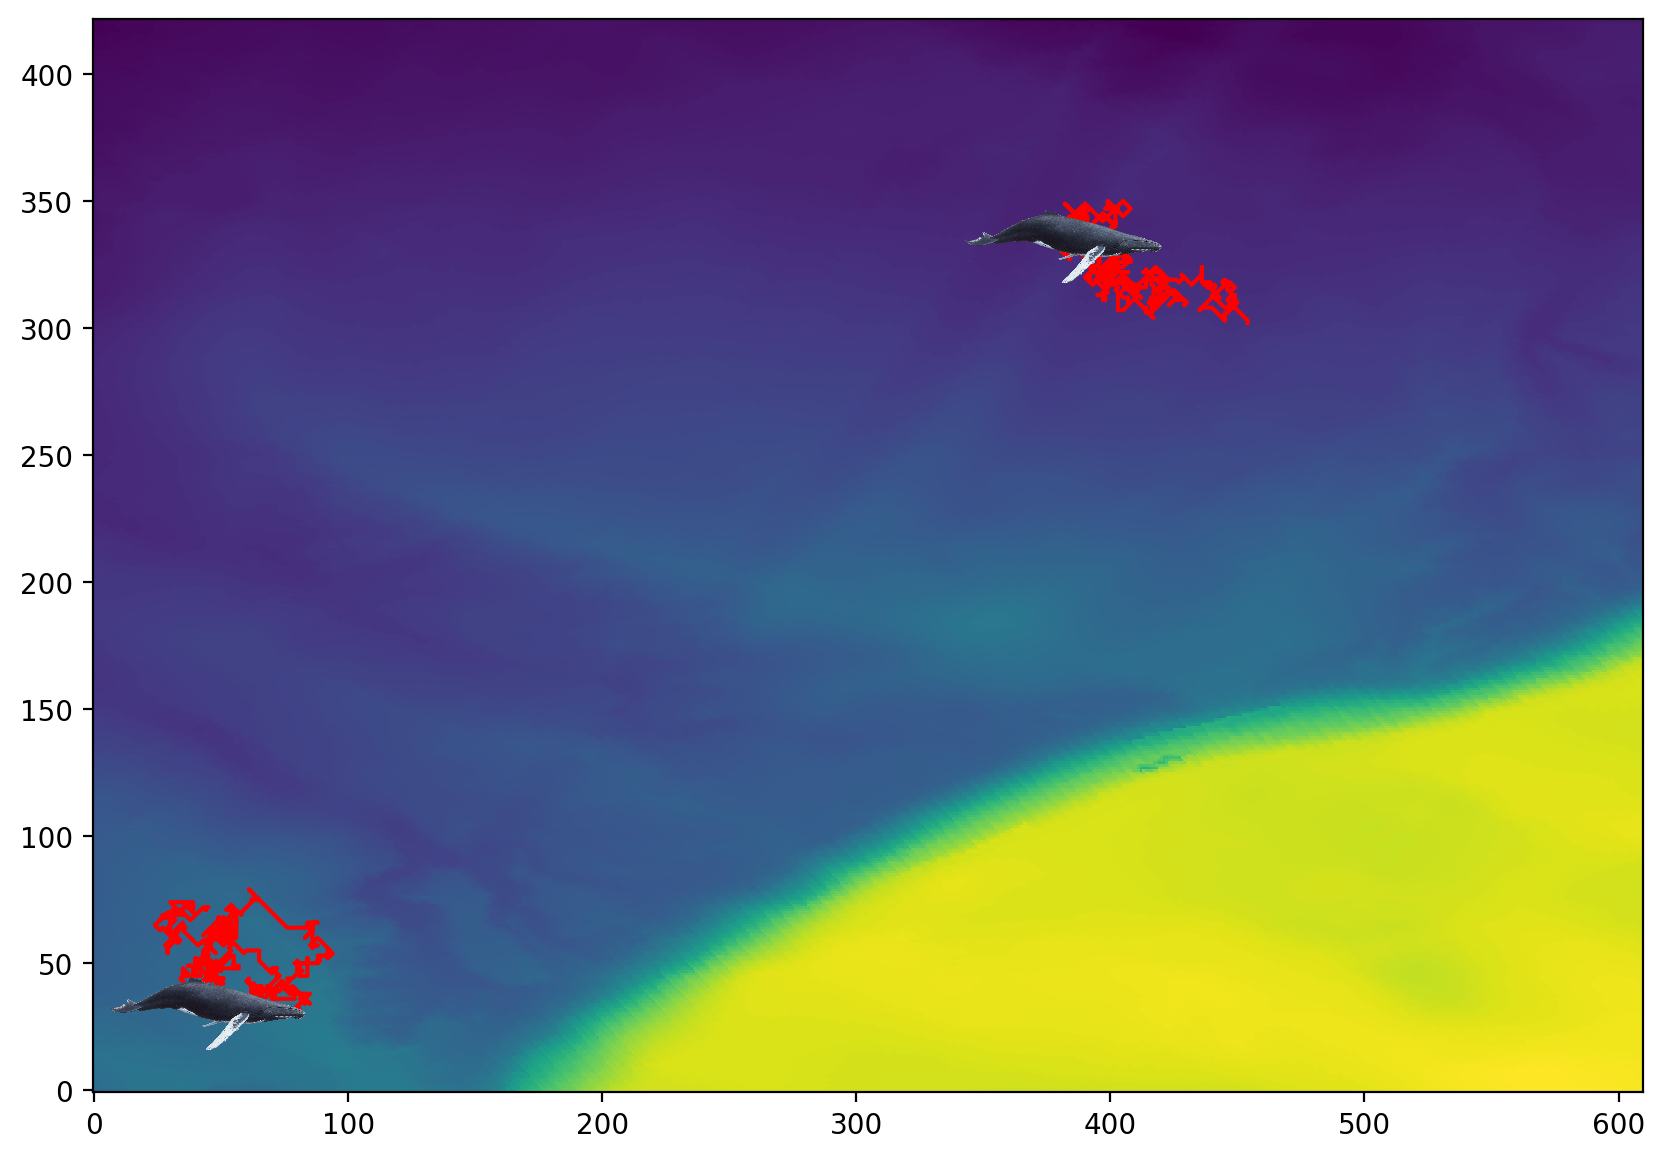

In [75]:
# Update path arrays
# Plot path and whale marker at most recent position
# Grab the image and add to the animation
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=15, bitrate=200000)

probabilities = {0: 0.58, 1: 0.58 + 0.07, 2: 0.58 + 0.07 + 0.19, 3: 0.58 + 0.07 + 0.19 + 0.05}
timesteps = 1000 # About a week

path_x_1 = []
path_y_1 = []
path_x_2 = []
path_y_2 = []
direction_1 = 'N'
direction_2 = 'N'

fig = plt.figure(dpi=200)
fig.set_figwidth(10)
fig.set_figheight(10)

with writer.saving(fig, "whale_test_1.mp4", dpi=200):
    for i in range(timesteps):
        fig.clear()
        
        turn = generate_turn()
        direction_1 = getNewDirection(direction_1, turn)
        pos_1 = updatePosition(pos_1, direction_1)
        
        turn = generate_turn()
        direction_2 = getNewDirection(direction_2, turn)
        pos_2 = updatePosition(pos_2, direction_2)
        
        if invalid(pos_1, map_data['elevation']):
            continue
        
        path_x_1.append(pos_1[0])
        path_y_1.append(pos_1[1])
        
        ax = plt.axes()
        ax.imshow(map_data['elevation'], origin='lower')
        ax.plot(path_x_1, path_y_1, 'r')
        curr_pos = (path_x_1[-1], path_y_1[-1])
        image = OffsetImage(plt.imread('humpback.png'), zoom=0.05)
        ab = AnnotationBbox(image, (curr_pos[0], curr_pos[1]), frameon=False)
        ax.add_artist(ab)
        plt.draw()
        
        if invalid(pos_2, map_data['elevation']):
            continue
            
        path_x_2.append(pos_2[0])
        path_y_2.append(pos_2[1])
        
        ax = plt.axes()
        ax.imshow(map_data['elevation'], origin='lower')
        ax.plot(path_x_2, path_y_2, 'r')
        curr_pos = (path_x_2[-1], path_y_2[-1])
        image = OffsetImage(plt.imread('humpback.png'), zoom=0.05)
        ab = AnnotationBbox(image, (curr_pos[0], curr_pos[1]), frameon=False)
        ax.add_artist(ab)
        plt.draw()
            
        writer.grab_frame()
        print(i)